In [ ]:
import pandas as pd
google_clusters = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AARRR/google_store_user_clusters.csv")

/tmp/ipython-input-1245600258.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  google_clusters = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AARRR/google_store_user_clusters.csv")


In [ ]:
google_clusters["visitStartTime"] = pd.to_datetime(google_clusters["visitStartTime"], utc=True)
google_clusters["date"] = pd.to_datetime(google_clusters["date"], utc=True)

In [ ]:
# 1) 원본 데이터 결측치 처리

google_clusters = google_clusters.fillna({
    "productPagesViewed": 0,
    "totalTimeOnSite": 0,
    "addedToCart": 0,
    "totalVisits":0,
    "totalHits":0,
    "totalPageviews":0,
})

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
google_df = google_clusters.copy()

In [ ]:
# 세션 단위 플래그 만들기
google_df["is_detail"] = (google_df["productPagesViewed"]>0)
google_df["is_search"] = (google_df["totalPageviews"]>1)
google_df["is_cart"] = (google_df["addedToCart"]>0)

In [ ]:
# 유저단위 요약집계

user = (
    google_df.groupby("fullVisitorId", as_index=False).agg(
        sessions=("fullVisitorId","count"),
        visit_days=("date","nunique"),  # totalVisits은 세션기준
        product_views=("productPagesViewed","sum"),
        carts=("addedToCart","sum"),
        total_time=("totalTimeOnSite","sum"),
        detail_sessions=("is_detail","sum"),
        search_sessions=("is_search","sum"),
        cart_sessions=("is_cart","sum"),
        last_date=("date","max")
        ))

# 분석 기준일(요청사항): 2017-06-01
today = pd.Timestamp("2017-06-01",tz="UTC")
user["days_since_last_visit"] = (today - user["last_date"]).dt.days.clip(lower=0)

In [ ]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594848 entries, 0 to 594847
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   fullVisitorId          594848 non-null  object             
 1   sessions               594848 non-null  int64              
 2   visit_days             594848 non-null  int64              
 3   product_views          594848 non-null  float64            
 4   carts                  594848 non-null  float64            
 5   total_time             594848 non-null  float64            
 6   detail_sessions        594848 non-null  int64              
 7   search_sessions        594848 non-null  int64              
 8   cart_sessions          594848 non-null  int64              
 9   last_date              594848 non-null  datetime64[ns, UTC]
 10  days_since_last_visit  594848 non-null  int64              
 11  recency                594848 non-null 

In [ ]:
# RFA 피처 만들기
# R (Recency) — 최근성: 값이 작을수록 최근
user["recency"] = user["days_since_last_visit"]

# F (Frequency) — 방문일수
user["frequency"] = user["visit_days"]

# A (Action) — 비율 지표들
user["cart_rate"]   = (user["cart_sessions"]   / user["sessions"]).fillna(0)
user["search_rate"] = (user["search_sessions"] / user["sessions"]).fillna(0)

In [ ]:
# 세션당 체류시간 & 전체 평균 대비 정규화
overall_avg_time_per_session = google_df["totalTimeOnSite"].sum() / len(google_df)  # 전체 세션 평균
user["time_per_session"] = (user["total_time"] / user["sessions"]).fillna(0)
user["time_per_session_norm"] = (user["time_per_session"] / max(1e-6, overall_avg_time_per_session)) # 고객 세션당 체류시간 정규화 -> 고객별로 차이가 커서 클러스터링 지배 가능성

In [ ]:
# 클러스터링용 핵십지표만 남기기
user_summery = user[["fullVisitorId","recency","frequency","cart_rate","search_rate","time_per_session_norm"]]

In [ ]:
features_df=user_summery.copy()

In [ ]:
# 다중공선성
features_df.corr()

,fullVisitorId,recency,frequency,cart_rate,search_rate,time_per_session_norm
fullVisitorId,1.000000,0.000267,0.000019,-0.000510,0.002399,-0.002419
recency,0.000267,1.000000,-0.061240,-0.023655,-0.022258,-0.037826
frequency,0.000019,-0.061240,1.000000,0.067579,0.048103,0.082885
cart_rate,-0.000510,-0.023655,0.067579,1.000000,0.217331,0.384651
search_rate,0.002399,-0.022258,0.048103,0.217331,1.000000,0.377361
time_per_session_norm,-0.002419,-0.037826,0.082885,0.384651,0.377361,1.000000


In [ ]:
corr = features_df.corr().abs()    # 절댓값으로 변환

In [ ]:
import numpy as np

In [ ]:
# 대각선(자기 자신과의 상관) 제외
upper = corr.where(~np.tril(np.ones(corr.shape)).astype(bool))

In [ ]:
# 0.8 이상인 쌍만 추출
high_corr = [
    (col, row, corr.loc[row, col])
    for row in upper.index
    for col in upper.columns
    if (pd.notnull(upper.loc[row, col]) and upper.loc[row, col] >= 0.8)
]

high_corr

[]

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF 계산
X = features_df.select_dtypes(include = [np.number]).dropna()
vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

vif_df = pd.DataFrame()
vif_df["feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_df.sort_values("VIF", ascending=False)

,feature,VIF
0,recency,2.135441
3,search_rate,2.049194
1,frequency,1.972311
4,time_per_session_norm,1.509559
2,cart_rate,1.241210


In [ ]:
# 가중치 설정 (균형형)
weights = {
    "frequency":2.0,
    "cart_rate":1.0,
    "time_per_session_norm":1.0
}

# 가중치 적용
features_weighted = features_df.copy()
for col, w in weights.items():
    features_weighted[col] = features_weighted[col] * w

In [ ]:
# 가중치 전
# elbow chart
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
scaler = StandardScaler() # 정규화
X_scaled = scaler.fit_transform(features_df)

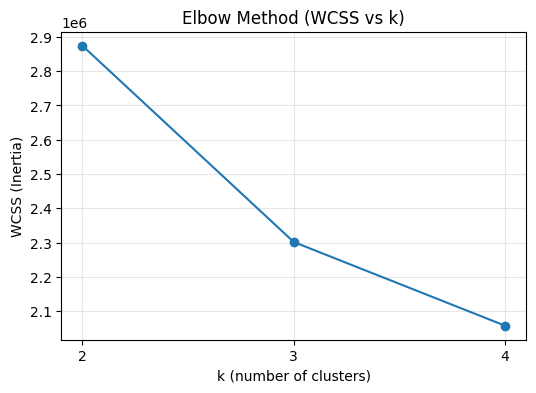

In [ ]:
K = range(2, 5)
wcss = []

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=50)
    km.fit(X_scaled)
    wcss.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, wcss, marker="o")
plt.title("Elbow Method (WCSS vs k)")
plt.xlabel("k (number of clusters)")
plt.ylabel("WCSS (Inertia)")
plt.xticks(K)
plt.grid(alpha=0.3)
plt.show()


In [ ]:
# 가중치
# elbow chart
scaler = StandardScaler() # 정규화
X_scaled2 = scaler.fit_transform(features_weighted)

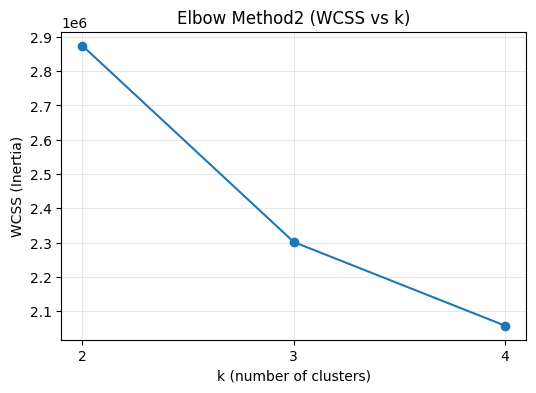

In [ ]:
K = range(2, 5)
wcss = []

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=50)
    km.fit(X_scaled2)
    wcss.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, wcss, marker="o")
plt.title("Elbow Method2 (WCSS vs k)")
plt.xlabel("k (number of clusters)")
plt.ylabel("WCSS (Inertia)")
plt.xticks(K)
plt.grid(alpha=0.3)
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=50)
user_summery["cluster"] = kmeans.fit_predict(X_scaled2)

/tmp/ipython-input-4178798056.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_summery["cluster"] = kmeans.fit_predict(X_scaled2)


In [ ]:
user_summery.head()

,fullVisitorId,recency,frequency,cart_rate,search_rate,time_per_session_norm,cluster
0,4823595352351,212,1,0.0,0.0,0.000000,1
1,5103959234087,284,1,0.0,1.0,1.556830,0
2,10278554503158,224,1,0.0,1.0,1.495173,0
3,20424342248747,183,1,0.0,1.0,2.289002,0
4,27376579751715,110,1,0.0,1.0,0.377647,0


In [ ]:
user_summery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594848 entries, 0 to 594847
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   fullVisitorId          594848 non-null  object 
 1   recency                594848 non-null  int64  
 2   frequency              594848 non-null  int64  
 3   cart_rate              594848 non-null  float64
 4   search_rate            594848 non-null  float64
 5   time_per_session_norm  594848 non-null  float64
 6   cluster                594848 non-null  int32  
dtypes: float64(3), int32(1), int64(2), object(1)
memory usage: 29.5+ MB


In [ ]:
# 클러스터링 프로파일링
cluster_profile = (user_summery.groupby("cluster")[["recency","frequency","cart_rate","search_rate","time_per_session_norm"]].mean().round(2))
cluster_size = user_summery["cluster"].value_counts().sort_index()

print(cluster_profile)
print(cluster_size)

         recency  frequency  cart_rate  search_rate  time_per_session_norm
cluster                                                                   
0         159.01       1.21       0.01         0.96                   1.19
1         164.43       1.07       0.00         0.01                   0.01
2         150.43       1.75       0.77         0.95                   5.32
cluster
0    260180
1    305542
2     29126
Name: count, dtype: int64


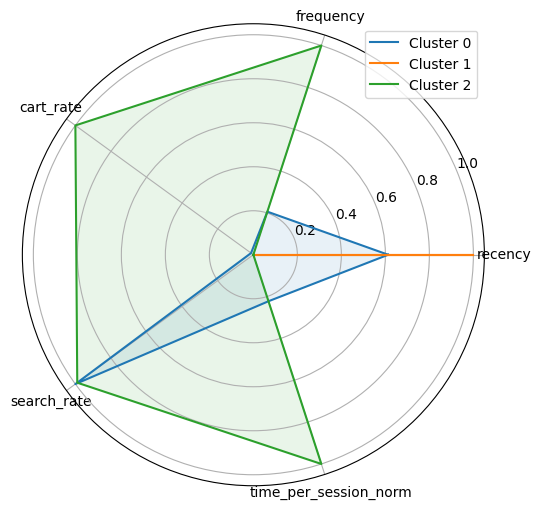

In [ ]:
import matplotlib.pyplot as plt

metrics = ["recency","frequency","cart_rate","search_rate","time_per_session_norm"]
cluster_profile_norm = cluster_profile.copy()

# 정규화 (0~1)
cluster_profile_norm = (cluster_profile_norm - cluster_profile_norm.min()) / (cluster_profile_norm.max() - cluster_profile_norm.min())

angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))

for idx, row in cluster_profile_norm.iterrows():
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, label=f"Cluster {idx}")
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.legend()
plt.show()

In [ ]:
# 클러스터 원본 만들기
google_with_cluster3 = google_clusters.merge(
    user_summery[["fullVisitorId","cluster"]],
    on="fullVisitorId",
    how="left"
)

In [ ]:
google_with_cluster3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748134 entries, 0 to 748133
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   fullVisitorId       748134 non-null  object             
 1   visitStartTime      748134 non-null  datetime64[ns, UTC]
 2   date                748134 non-null  datetime64[ns, UTC]
 3   deviceCategory      748134 non-null  object             
 4   isMobile            748134 non-null  bool               
 5   operatingSystem     748134 non-null  object             
 6   browser             748134 non-null  object             
 7   country             748134 non-null  object             
 8   city                748134 non-null  object             
 9   trafficSource       748134 non-null  object             
 10  trafficMedium       748134 non-null  object             
 11  trafficCampaign     748134 non-null  object             
 12  isFirstVisit    

In [ ]:
google_with_cluster3.head()

,fullVisitorId,visitStartTime,date,deviceCategory,isMobile,operatingSystem,browser,country,city,trafficSource,trafficMedium,trafficCampaign,isFirstVisit,totalVisits,totalHits,totalPageviews,totalTimeOnSite,productPagesViewed,addedToCart,cluster
0,4214259466202417480,2016-10-15 00:55:57+00:00,2016-10-14 00:00:00+00:00,desktop,False,Windows,Internet Explorer,United States,not available in demo dataset,ask,organic,(not set),False,1.0,2.0,2.0,16.0,0.0,0.0,2
1,3541738396641160713,2017-05-01 04:00:05+00:00,2017-04-30 00:00:00+00:00,desktop,False,Windows,Chrome,United States,not available in demo dataset,ask,organic,(not set),False,1.0,1.0,1.0,0.0,0.0,0.0,1
2,8276557623242379934,2017-03-21 04:39:07+00:00,2017-03-20 00:00:00+00:00,desktop,False,Windows,Chrome,Australia,Brisbane,ask,organic,(not set),False,1.0,2.0,2.0,16.0,0.0,0.0,1
3,5855313117666192014,2017-04-01 12:00:53+00:00,2017-04-01 00:00:00+00:00,desktop,False,Windows,Chrome,Australia,Sydney,ask,organic,(not set),False,1.0,1.0,1.0,0.0,0.0,0.0,2
4,2619633492044211273,2017-05-20 14:59:36+00:00,2017-05-20 00:00:00+00:00,desktop,False,Windows,Chrome,United States,not available in demo dataset,ask,organic,(not set),False,1.0,15.0,12.0,326.0,1.0,1.0,2


In [ ]:
google_with_cluster3['cluster'].value_counts()

,count
cluster,
1,343682
0,342506
2,61946


In [ ]:
# 1) 유저 단위로 중복 제거
user_unique = google_with_cluster3[["fullVisitorId", "cluster"]].drop_duplicates()

In [ ]:
# 2) 클러스터별 유저 수 집계
user_cluster_counts = (
    user_unique["cluster"].value_counts()
    .rename_axis("cluster")
    .reset_index(name="user_count")
)

In [ ]:
user_cluster_counts

,cluster,user_count
0,1,305542
1,0,260180
2,2,29126


In [ ]:
# 다운로드
from google.colab import files

# CSV 저장
google_with_cluster3.to_csv("google_with_cluster3.csv", index=False)

# 로컬로 다운로드
files.download("google_with_cluster3.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# --- k=2~5 실루엣 점수 계산 ---
Ks = range(2, 5)
scores = []
for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=50)
    labels = km.fit_predict(X_scaled2)
    score = silhouette_score(X_scaled2, labels)
    sample_size = 10000,
    random_state= 42,
    scores.append(score)
    print(f"k={k}, silhouette={score:.4f}")

k=2, silhouette=0.2795
k=3, silhouette=0.3058
